[View in Colaboratory](https://colab.research.google.com/github/Aleadinglight/Pytorch-VGG-19/blob/master/VGG_19.ipynb)

### Install Pytorch and Pillow

In [0]:
!pip3 install -q http://download.pytorch.org/whl/cu90/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip install Pillow==4.1.1

### Down load two sample images.

In [0]:
!mkdir images
!wget -P ./images "https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg"
!wget -P ./images "https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg"

### Test to see if the download is done succesfully.

In [32]:
!ls images

dancing.jpg  picasso.jpg


### Down load the VGG 19 model

In [4]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:32<00:00, 17463153.45it/s]


## Checking the VGG-19 architect

In [5]:
print(cnn)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

### Preparing data and images

We define the image size to be 512 if we train it on GPU, otherwise we resize it to 128.

In [0]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

# resize the image and convert it to a tensor
loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    # return image to torch tensor
    return image.to(device, torch.float)


style_img = image_loader("images/picasso.jpg")
content_img = image_loader("images/dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

Show the image

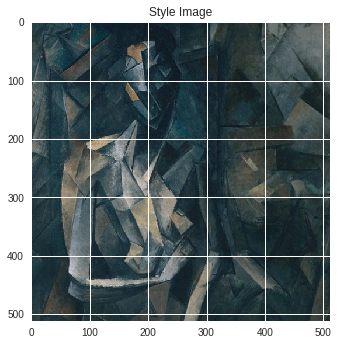

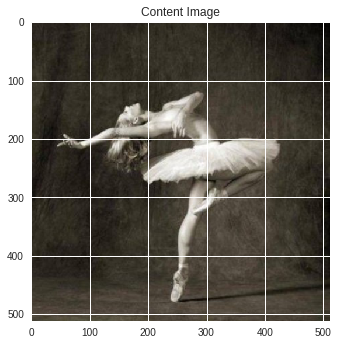

In [7]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

### Compute the content loss
Let' s define $ F_{XL}$ is the feature maps at layer L in a network fed by input image X. Say we have another image Y (same size), then the different between two content is: $(F_{XL} - F_{YL})^2$ (Mean Square Error between the two sets of feature maps, that can be computed using a criterion `nn.MSELoss()` stated as a third parameter). 

We will add our content losses at each desired layer as additive modules of the neural network. Every time we feed in an image X, all the content loss at the desire layer will be computed.

`.detach()` is like making a copy of it without having the node in the gradient graph, so it won't catch error when we run.

In [0]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

### Compute the style loss

#### Gram matrix
Gram matrix wiki: http://mlwiki.org/index.php/Gram_Matrices

A gram matrix of **V** is a matrix of all posible inner product of **V**: $G_{V} = V^TV$ 

Gram matrix of a set of images represents the similarity (or difference) between two images. If you have an (m x n) image, reshape it  to a (m*n x 1) vector. Similarly convert all images to vector form and form a matrix ,say: **M** then the gram matrix ** G ** of these set of images will be
**$G = M^T M$**

Let $F^k_{XL}$  be the vectorized $k^{th}$ of the K feature maps at layer L => **G** is of size: **K**x**K**

In [0]:
def gram_matrix(input):
    # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a feature map (N=c*d)
    a, b, c, d = input.size()  
    

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

#### Styleloss

The styleloss, therefore, is computing by the mean square error of the following Gram matrix at layer L of two input image X and Y:

** $||G_{XL}-G_{YL}||^2$ **

In [0]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

### Normalization




In [0]:
# mean and standard deviation from the data set
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

### Adding module

We add style and content loss modules as additive ‘transparent’ layers in our network, at desired depths. For that, we construct a new Sequential module, in which we are going to add modules from **VGG-19** and our loss modules in the right order. In this case, we loop through each layer in this Sequential module. The **content_layers_default** specify the layer that you want to compute the content loss, same case to **style_layers_default**. 


In [0]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

### Optimization
We will use L-BFGS algorithm to run our gradient descent as Leon Gatys suggest. Unlike training a network, we want to train the input image in order to minimise the content/style losses. We would like to simply create a PyTorch L-BFGS optimizer optim, passing our image as the Tensor to optimize.

In [0]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

### Training

At each step, we must feed in the input and compute the loss. Then we update the input and continue feeding it into the network.

We also need to correct the images to maintain it value from 0 - 1.

In [0]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)
            # clear the previous gradient
            optimizer.zero_grad()
            # feed in the input img
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

### Run the algorithm

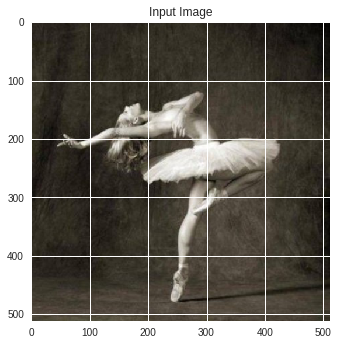

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 4.157101 Content Loss: 4.259924

run [100]:
Style Loss : 1.147710 Content Loss: 3.057359

run [150]:
Style Loss : 0.714217 Content Loss: 2.661026

run [200]:
Style Loss : 0.478059 Content Loss: 2.498811

run [250]:
Style Loss : 0.345043 Content Loss: 2.413057

run [300]:
Style Loss : 0.263235 Content Loss: 2.358690



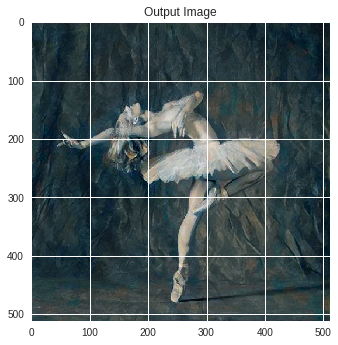

In [16]:
input_img = content_img.clone()
# if you want to use a white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

### Play ground

In case you want to upload your own picture.

In [34]:
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())
a = upload_files()

Saving style.jpg to style (1).jpg


Picture's size: torch.Size([1, 3, 960, 960])
torch.Size([1, 3, 960, 960])


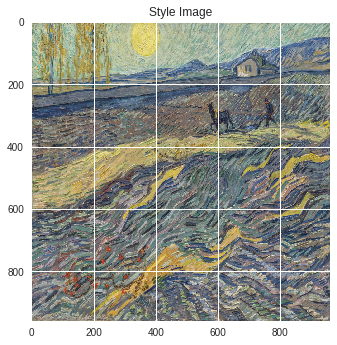

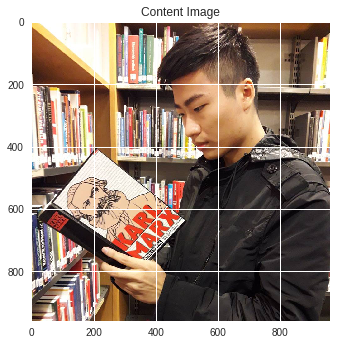

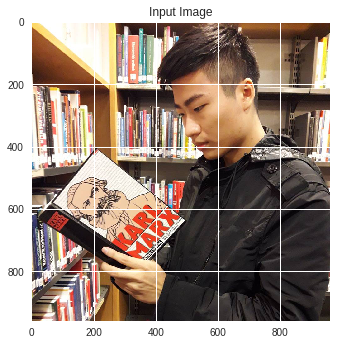

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 64.026093 Content Loss: 19.447691

run [100]:
Style Loss : 15.622391 Content Loss: 17.689804

run [150]:
Style Loss : 7.489441 Content Loss: 15.512869

run [200]:
Style Loss : 4.623196 Content Loss: 13.490669

run [250]:
Style Loss : 2.672395 Content Loss: 12.129458

run [300]:
Style Loss : 1.650170 Content Loss: 11.208418



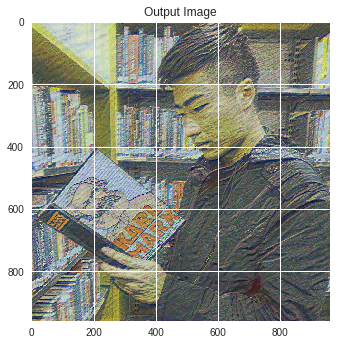

In [44]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

# resize the image and convert it to a tensor
loader = transforms.Compose([
    transforms.Resize((imsize,imsize)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    # return image to torch tensor
    return image.to(device, torch.float)

style_img = image_loader("style.jpg")
content_img = image_loader("ava.jpg")

print("Picture's size:",style_img.size())
print(content_img.size())
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

input_img = content_img.clone()
# if you want to use a white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()